In [5]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats

# Preprocessing

Primerament, he volgut observar les dades proveides en el dataset, entrendre la seva distribució o si ens feia falta fer neteja d'aquest, o per exemple balancejar-lo.


In [6]:
from src.generate_features import *

# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

dataset_train, dataset_test, dataset_validate, dataset_full = generate_dataset(type='non-nlp')

data = dataset_test.values
target = dataset_test.target

x = data[:, :18]
y = target

print("Dimensionalitat de la BBDD:", dataset_full.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)

Index(['COLUMNS: decade', 'COLUMNS: danceability', 'COLUMNS: energy',
       'COLUMNS: key', 'COLUMNS: loudness', 'COLUMNS: mode',
       'COLUMNS: speechiness', 'COLUMNS: acousticness',
       'COLUMNS: instrumentalness', 'COLUMNS: liveness', 'COLUMNS: valence',
       'COLUMNS: tempo', 'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')
Dimensionalitat de la BBDD: (41106, 17)
Dimensionalitat de les entrades X (18499, 17)
Dimensionalitat de l'atribut Y (18499,)


Dintre de la generació del nostre dataset, es a dir la carrega del mateix en un Dtaframe de Pandas i possible neteja, he dividit el proces en 2 parts. Primerament, vaig voler probar a  utilitzar el dataset proveit tal qual, eliminant les columnes amb text com per exemple el nom del artista o URL de spotify de la canço. Més endavant, (apartat NLP d'aquest notebook) vaig voler probar a utilitzar Natural Language Processing per probar si per exemple podria extreure coneixemtn util dels noms de les cançons.

Ambdos idees es tradueixen en la funció generate_dataset que li puc passar l'argument 'NLP' o 'non-nlp' respectivament. 

El meu dataset estava dividit en diferents .csv depenent de cada decada:

    - 60 (Decada dels 60 - 1960-1970)
    - 70 (Decada dels 60 - 1970-1980)
    - 80 (Decada dels 60 - 1980-1990)
    - 90 (Decada dels 60 - 1990-2000)
    - 00 (Decada dels 60 - 2000-2010)
    - 10 (Decada dels 60 - 2010-2020)
    
Aleshores, la idea que he seguit es la de juntar tots els datasets desde la decada dels 60 fins als 90 per a train, deixant la ultima o ultimes decades (00, 10) per dades de test. Com veurem més endavant cada decada es important, la música ha anat evolucionant, aixi com el concepte de canço exitosa.

Primerament observem el nombre de valors nulls. Podem observar que no presentem cap.

In [4]:
print("Per comptar el nombre de valors no existents:")
print(dataset_full.isnull().sum())

Per comptar el nombre de valors no existents:
decade              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64


El nostre arbre tampoc esta desbalancejat, tenim el mateix nombre de dades de ambdos classes:

In [5]:
print(dataset_full['target'].value_counts())


1    20553
0    20553
Name: target, dtype: int64


Per introduir-les, trobem aquestes variables depenents el seu valor de cada canço. Com veurem més endavant hi ha variiables que han tingut més importancia que altres durant les diferents decades peró que realment s'ha mantingut sempre com les numero 1.
Aquestes dades s'extreuen amb la API de Spotify de Sound Analysis, que també he utilitzat en la creació de la pagina web.

In [6]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")
dataset_full.head() 

Per visualitzar les primeres 5 mostres de la BBDD:


,decade,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
0,1960,0.417,0.620,3,-7.727,1,0.040,0.490,0.000,0.078,0.845,185.655,173533,3,32.950,9,1
1,1960,0.498,0.505,3,-12.475,1,0.034,0.018,0.107,0.176,0.797,101.801,213613,4,48.825,10,0
2,1960,0.657,0.649,5,-13.392,1,0.038,0.846,0.000,0.119,0.908,115.940,223960,4,37.227,12,0
3,1960,0.590,0.545,7,-12.058,0,0.104,0.706,0.025,0.061,0.967,105.592,157907,4,24.755,8,0
4,1960,0.515,0.765,11,-3.515,0,0.124,0.857,0.001,0.213,0.906,114.617,245600,4,21.799,14,0


Anem a analtizar les dades. Com tenim diferents decades, vaig observar que potser, clar, la música a anat evolucionant amb el temps, aixi com els gustos de la gent, o factors que determinen quina canó es un exit. Per tant, primerament vaig mostrar en una grafica la mitjana de hits i no hits depenent de cada factor.

<IPython.core.display.Javascript object>


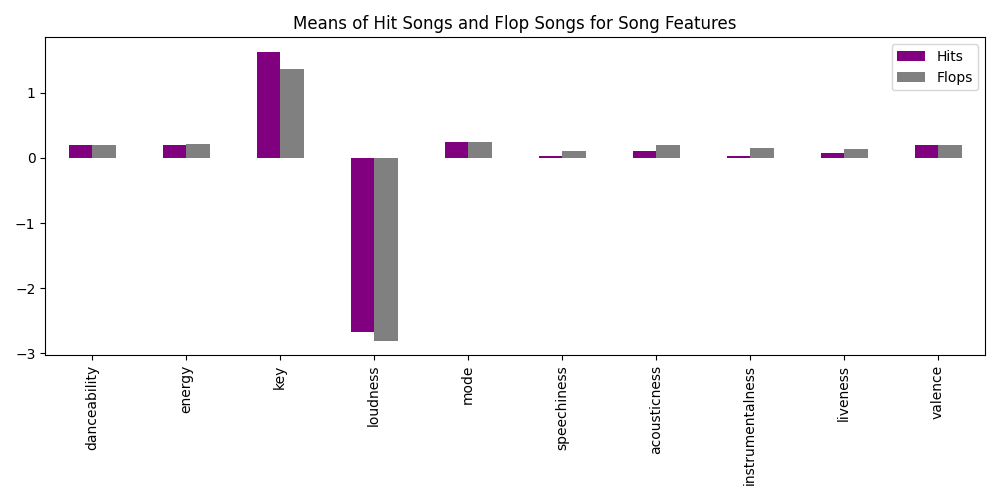

In [7]:
from sklearn.preprocessing import StandardScaler 
#create two var lists, one with Spotify's features (spfeatures_var_list) and one with the song traits (song_traits_var_list)
spfeatures_var_list = ['danceability', 'energy', 'key', 'loudness','mode', 'speechiness', 'acousticness', 
                       'instrumentalness', 'liveness','valence']
song_traits_var_list = ['key', 'loudness','tempo', 'time_signature', 'chorus_hit','sections'] 
#duration_ms has been removed since it has such larger numbers than the other variables 

all_songs_hits = dataset_train[spfeatures_var_list].loc[dataset_train['target'] == 1]

all_songs_flops = dataset_train[spfeatures_var_list].loc[dataset_train['target'] == 0]

#create a dataframe that includes the means for hits and flops
hits_means = pd.DataFrame(all_songs_hits.describe().loc['mean'])
flops_means = pd.DataFrame(all_songs_flops.describe().loc['mean'])
means_joined = pd.concat([hits_means,flops_means], axis = 1)
means_joined.columns = ['hit_mean', 'flop_mean']

ss = StandardScaler()
means_joined_scaled = pd.DataFrame(ss.fit_transform(means_joined),index= means_joined.index, columns = means_joined.columns)
means_joined_scaled


means_joined_scaled.plot(kind = 'bar', figsize=(10, 5), color = ('purple', 'grey'), title = 'Means of Hit Songs and Flop Songs for Song Features')
plt.legend(labels=['Hits', 'Flops'], loc='upper right')
plt.tight_layout()
plt.show()

Com es pot anar observant, la key o tonalitat musical en la que es troba la cançó així com el loudness, presenten molt més pes que les altres.
Anem a veure l'histograma de cada variable per buscar les distribucions de les nostres variables

<IPython.core.display.Javascript object>


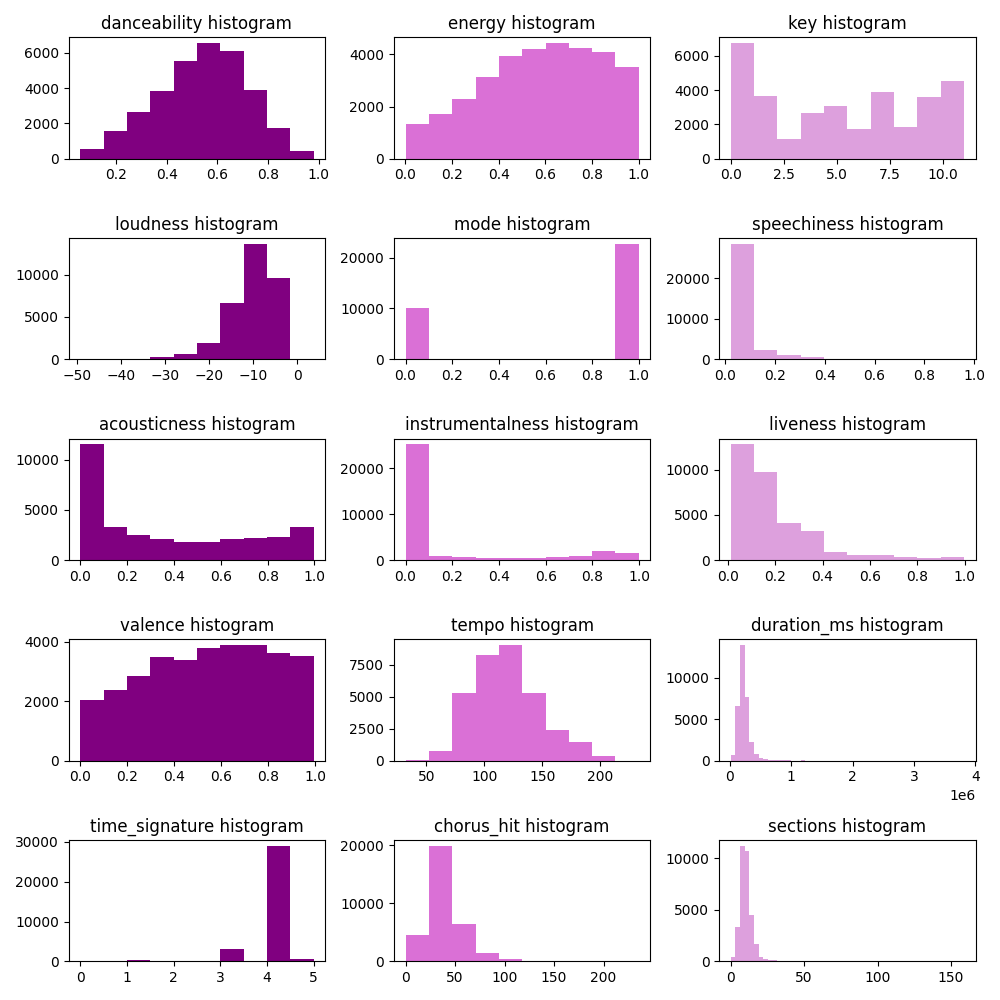

In [8]:
#create histograpms of all the variables to see distributions
fig, ax = plt.subplots(5,3, figsize=(10, 10))
fig.tight_layout()

def hist_plot(row, column, variable, binsnum, color):
    ax[row, column].hist(dataset_train[variable], bins = binsnum, color = color)
    ax[row, column].set_title(variable + ' histogram')
    
hist_plot(0, 0, 'danceability', 10, 'purple')
hist_plot(0, 1, 'energy', 10, 'orchid')
hist_plot(0, 2, 'key', 10, 'plum')
hist_plot(1,0, 'loudness', 10, 'purple')
hist_plot(1,1, 'mode', 10, 'orchid')
hist_plot(1,2, 'speechiness', 10, 'plum')
hist_plot(2,0, 'acousticness', 10, 'purple')
hist_plot(2,1, 'instrumentalness', 10, 'orchid')
hist_plot(2,2, 'liveness', 10, 'plum')
hist_plot(3,0, 'valence', 10, 'purple')
hist_plot(3,1, 'tempo', 10, 'orchid')
hist_plot(3,2, 'duration_ms', 50, 'plum')
hist_plot(4,0, 'time_signature', 10, 'purple')
hist_plot(4,1, 'chorus_hit', 10, 'orchid')
hist_plot(4,2, 'sections', 50, 'plum')
plt.tight_layout()
plt.show()

Aquí hi ha alguns patrons interessants: les cançons solen ser més ballables que menys ballables, les cançons tendeixen a tenir més energia que menys energia, la tonalitat de C és la tonalitat més popular, les cançons solen ser inferiors a 10 decibels, la majoria de les cançons estan en escales majors, la majoria de les cançons contenen més música que la parla, la majoria de les cançons no són en directe, la majoria de les cançons no són acústiques, la majoria de les cançons contenen música, hi ha una bona barreja de cançons alegres i tristes, la majoria de cançons tenen uns 80-90 pulsacions per minut i la majoria de cançons són en 4/4 de temps. 

En el apartat de Model Testing, s'observara amb més profunditat altres factors de les dades.

#  Model Testing

Primer vaig començar per probar diferents models estadistics classificadors per veure quin hem donava millor resultat. L'escull dels mateixos ha sigut un process de busqueda en internet dels més recomenats, i amb comparar amb altres persones que han treballat en aquest cas Kaggle també.

In [9]:
from src.train_model import *

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

x_train, x_test, y_train, y_test = get_train_test(dataset_train, dataset_test, dataset_validate)


models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": SVC(max_iter=5000),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Net": MLPClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    print(name)
    model.fit(x_train, y_train)
    print(name + " trained.")

for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(x_test, y_test) * 100))
    print("----------------")
    print("Model evaluation {0}".format(name))
    evaluate_model(x_train, x_test, y_train, y_test, model.predict(x_test), model)
    # print("###")
    print("Cross validation {0}".format(name))
    # print("###")
    # cross_val_preds = cross_val_predict(model, x_val, y_val)
    scores = cross_val_score(model, x_train, y_train, cv=6, scoring='accuracy')
    print("Cross-validation scores:", scores)
    print("Mean:", scores.mean())
    print("----------------")


D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = dataset_train.drop(['target'], 1).values  # values converts it into a numpy array
D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = dataset_test.drop(['target'], 1).values  # values converts it into a numpy array


Logistic Regression
Logistic Regression trained.
K-Nearest Neighbors
K-Nearest Neighbors trained.
Decision Tree
Decision Tree trained.
Support Vector Machine (Linear Kernel)


c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Support Vector Machine (Linear Kernel) trained.
Random Forest
Random Forest trained.
Naive Bayes
Naive Bayes trained.
Neural Net


c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Net trained.
AdaBoost
AdaBoost trained.
Gradient Boosting
Gradient Boosting trained.
Logistic Regression: 73.57%
----------------
Model evaluation Logistic Regression
Accuracy: 73.57154440780582
Precision: 69.9825479930192
Recall: 82.45670995670996
F1 score: 0.7570924628608336
Training MSE:  0.2546145659115098
Test model MSE 0.2642845559219417
Cross validation Logistic Regression
Cross-validation scores: [0.67651888 0.69750046 0.72851669 0.76975005 0.7932859  0.7540146 ]
Mean: 0.7365977624094916
----------------
K-Nearest Neighbors: 72.45%
----------------
Model evaluation K-Nearest Neighbors
Accuracy: 72.44715930590843
Precision: 69.03777226357872
Recall: 81.2987012987013
F1 score: 0.7466825704487848
Training MSE:  0.1391211798692413
Test model MSE 0.27552840694091574
Cross validation K-Nearest Neighbors
Cross-validation scores: [0.68746579 0.73070608 0.72979383 0.76902025 0.77358146 0.74470803]
Mean: 0.7392125739837377
----------------
Decision Tree: 71.38%
----------------
Mo

c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\users

Cross-validation scores: [0.71428571 0.73453749 0.72505017 0.74895092 0.79182631 0.77864964]
Mean: 0.7488833743731386
----------------
Random Forest: 80.02%
----------------
Model evaluation Random Forest
Accuracy: 80.01513595329477
Precision: 77.29197439684884
Recall: 84.94588744588745
F1 score: 0.8093838618200566
Training MSE:  0.00012163600425726015
Test model MSE 0.19984864046705228
Cross validation Random Forest
Cross-validation scores: [0.77996716 0.82995804 0.85531837 0.863711   0.86389345 0.81587591]
Mean: 0.8347873221404978
----------------
Naive Bayes: 70.78%
----------------
Model evaluation Naive Bayes
Accuracy: 70.77679874587815
Precision: 65.59297218155197
Recall: 87.27272727272727
F1 score: 0.7489551407077181
Training MSE:  0.28882469210886424
Test model MSE 0.29223201254121844
Cross validation Naive Bayes
Cross-validation scores: [0.68272213 0.7044335  0.69549352 0.71081919 0.73782157 0.69580292]
Mean: 0.7045154717180475
----------------
Neural Net: 78.78%
-------------

c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

Cross-validation scores: [0.72687466 0.76774311 0.77741288 0.81390257 0.83178252 0.78613139]
Mean: 0.7839745220272111
----------------
AdaBoost: 76.24%
----------------
Model evaluation AdaBoost
Accuracy: 76.24195902481216
Precision: 73.16630008606676
Recall: 82.8030303030303
F1 score: 0.7768695740468091
Training MSE:  0.21894480766306826
Test model MSE 0.23758040975187847
Cross validation AdaBoost
Cross-validation scores: [0.69987229 0.73289546 0.74657909 0.7812443  0.81919358 0.78813869]
Mean: 0.76132056615843
----------------
Gradient Boosting: 78.90%
----------------
Model evaluation Gradient Boosting
Accuracy: 78.89615654900265
Precision: 75.2364737041241
Recall: 86.08225108225108
F1 score: 0.8029477084595195
Training MSE:  0.19154629770412043
Test model MSE 0.2110384345099735
Cross validation Gradient Boosting
Cross-validation scores: [0.74256523 0.76299945 0.77504105 0.80678708 0.84820288 0.80018248]
Mean: 0.7892963626613682
----------------


Com podem veure, el model de Random Forest ens retorna l'accuracy més alt aixi com una precissió i recall més bona. Per tant haurem de treballar amb aquest. El seguent que volia veure era buscar quines variables ens ajuden a diferenciar entre HIT i no HIT.

Anem a crear un model de random forest i provar rendiments

D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = dataset_train.drop(['target'], 1).values  # values converts it into a numpy array
D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = dataset_test.drop(['target'], 1).values  # values converts it into a numpy array


<IPython.core.display.Javascript object>


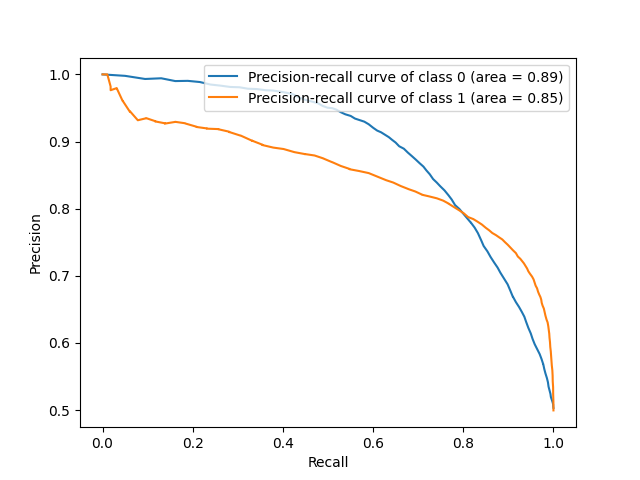

<IPython.core.display.Javascript object>


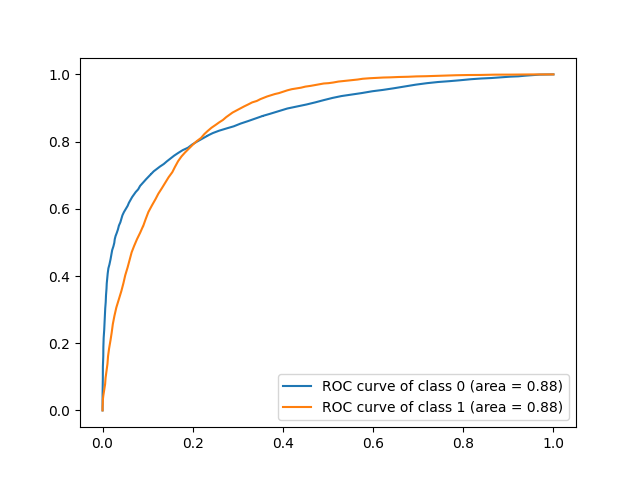

In [7]:
from src.train_model import *
from src.graphic_utils import *
import matplotlib as mpl
import seaborn as sns

x_train, x_test, y_train, y_test = get_train_test(dataset_train, dataset_test, dataset_validate)

RF = RandomForestClassifier()
RF.fit(x_train, y_train)
y_pred = RF.predict(x_test)

probs = RF.predict_proba(x_test)
roc_and_pr(y_test, probs)



Ambdos curbes ens indican que tot i que podria arribar a ser més perfecte, el nostre model es bastant bo classificant, veiem com la area per sota de la corva es molt propera a 1.

<IPython.core.display.Javascript object>


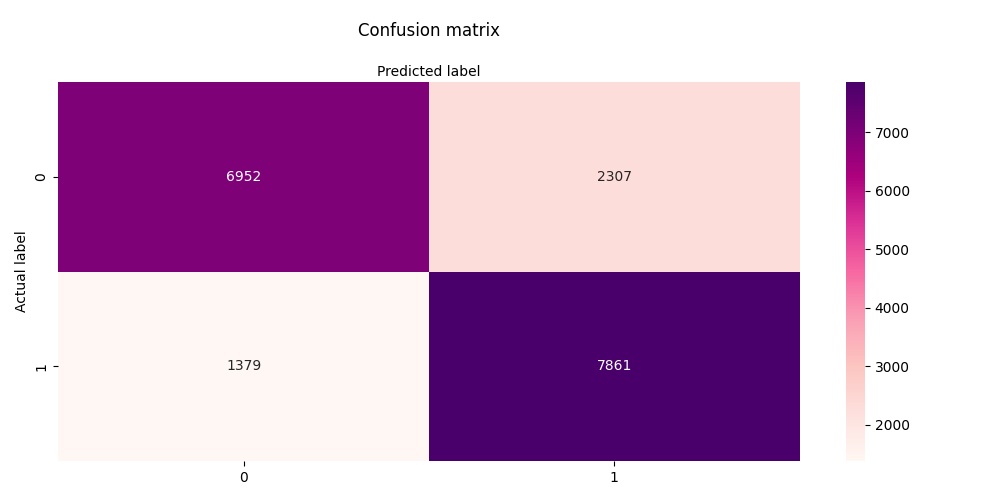

In [11]:
#create a confusion matrix to see the efficacy of the model
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

#create a figure/heatmap of the confusion matrix for a better visual
mpl.rcParams['figure.figsize']=(10,5)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="RdPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

La matriu de confusió demostra que el model va identificar correctament els encerts i els fracàs la majoria del temps.
Podem observar com al pas de les decades, com de importants son cara atribut de les cançons ja que possiblement depenent de la decada, li donaven mes importancia potser al tant per cent de ballable  i no tant al tant percent de instrumentabilitat.


                  Feature importance all decades
Variable                                        
instrumentalness                           0.171
acousticness                               0.113
danceability                               0.100
energy                                     0.076
speechiness                                0.073
loudness                                   0.073
duration_ms                                0.072
valence                                    0.065
tempo                                      0.050
liveness                                   0.047
chorus_hit                                 0.045
decade                                     0.038
sections                                   0.034
key                                        0.026
mode                                       0.009
time_signature                             0.006
16 16


<IPython.core.display.Javascript object>


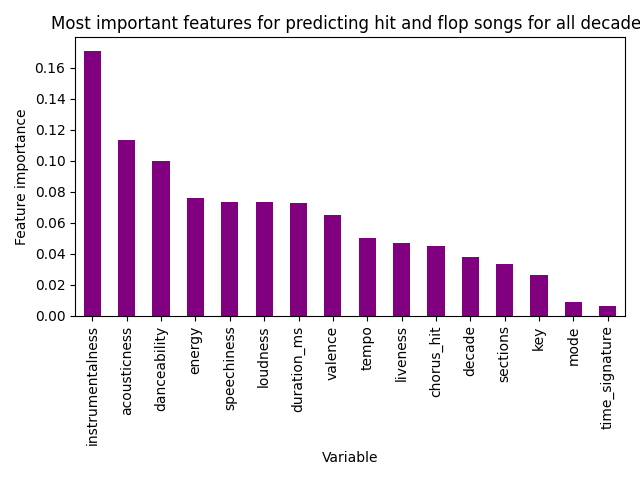

In [8]:
indep_columns = ['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature', 'chorus_hit',
       'sections', 'decade']

#create a dataframe of the feature importances to determine which variables are the most important in determining a hit
all_songs_feat = RF.feature_importances_
df_indep_columns = pd.DataFrame(indep_columns)
df_all_songs_feat = pd.DataFrame(all_songs_feat)

all_songs_feat_vars = pd.concat([df_indep_columns, df_all_songs_feat], axis = 1, ignore_index=True)

all_songs_feat_vars.columns = ['Variable', 'Feature importance all decades']
all_songs_feat_vars = all_songs_feat_vars.set_index('Variable')
all_songs_feat_vars = all_songs_feat_vars.sort_values(by=['Feature importance all decades'], ascending = False)
print(all_songs_feat_vars)
print(RF.n_features_in_, len(indep_columns))

all_songs_feat_vars.plot(kind='bar', color = "purple", title = "Most important features for predicting hit and flop songs for all decades", legend = None)
plt.ylabel('Feature importance')
plt.tight_layout()
plt.show()

Durant totes les dècades, instrumentalness, danceability, acousticness, duration_ms, i loudness van ser els millors predictors de si una cançó era un èxit. Tot i aixi, he comprobat que deixant aquests valors com a unics atributs d'entrada, les metriques empitjoraven. Aixó ens indica que aquests atributs son importants en tant a visió general de la societat i els seus gustos en cada decada, pero els altres atributs més tecnics de cada cançó son desconeguts pel public general pero jugent gran paper.

# Hyperparameter Search

Per intentar obtenir millors rendiments, he decidit fer una busqueda dels millors hiperparametres per al nostre random forest. Per aixo, he utilizat la llibreria scikit-optimize, en especial el Buscador de Bayes amb cross validation.

In [13]:
def hyperparameter_search(x_train, y_train, x_test, y_test, model_name, params=None):
    """ retrain model with new song """
    sc =  StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    
    # use grid search to find best parameters for random forest

    from skopt import BayesSearchCV

    from skopt.space import Real, Categorical, Integer

    # log-uniform: understand as search over p = exp(x) by varying x
    opt = BayesSearchCV(
        RandomForestClassifier(),
        {
            'n_estimators': Integer(1, 500),
            'max_depth': Integer(1, 20),
            'max_features': Categorical(['auto', 'sqrt', 'log2']),
            'min_samples_split': Integer(2, 20),
            'min_samples_leaf': Integer(1, 20),
            'bootstrap': Categorical([True, False]),
            'criterion': Categorical(['gini', 'entropy']),
        },
        n_iter=32,
        random_state=0,
        verbose=2
    )

    # executes bayesian optimization
    _ = opt.fit(x_train, y_train)

    # model can be saved, used for predictions or scoring
    print(opt.score(x_test, y_test))
    print(opt.best_params_)
    print(opt.best_score_)
    print(opt.best_estimator_)

    return opt.score(x_test, y_test)

In [14]:
dataset_train, dataset_test, dataset_validate, dataset_full = generate_dataset(type='non-nlp')

x_train, x_test, y_train, y_test = get_train_test(dataset_train, dataset_test, dataset_validate)

score = hyperparameter_search(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, model_name='RF')


Index(['COLUMNS: decade', 'COLUMNS: danceability', 'COLUMNS: energy',
       'COLUMNS: key', 'COLUMNS: loudness', 'COLUMNS: mode',
       'COLUMNS: speechiness', 'COLUMNS: acousticness',
       'COLUMNS: instrumentalness', 'COLUMNS: liveness', 'COLUMNS: valence',
       'COLUMNS: tempo', 'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')


D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:36: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_train = dataset_train.drop(['target'], 1).values  # values converts it into a numpy array
D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x_test = dataset_test.drop(['target'], 1).values  # values converts it into a numpy array


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.7s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.7s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.8s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.8s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=18, max_features=log2, min_samples_leaf=6, min_samples_split=5, n

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=19, min_samples_split=2, n_estimators=58; total time=   4.4s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=19, min_samples_split=2, n_estimators=58; total time=   4.6s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=19, min_samples_split=2, n_estimators=58; total time=   4.4s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=19, min_samples_split=2, n_estimators=58; total time=   6.2s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=19, min_samples_split=2, n_estimators=58; total time=   4.9s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=278; total time=  25.2s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=278; total time=  23.5s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=278; total time=  25.1s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=278; total time=  28.0s
[CV] END bootstrap=True, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=278; total time=  27.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_sampl

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=33; total time=   3.2s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=33; total time=   3.3s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=33; total time=   3.7s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=33; total time=   3.3s
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=7, n_estimators=33; total time=   3.2s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=13, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_esti

In [17]:
RF = RandomForestClassifier(random_state=0,bootstrap=False, criterion='entropy',max_depth=20, max_features='log2', min_samples_leaf=1,min_samples_split=7,n_estimators=175)
RF.fit(x_train, y_train)

evaluate_model(x_train, x_test, y_train, y_test, model.predict(x_test), model)
scores = cross_val_score(model, x_train, y_train, cv=6, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean:", scores.mean())

Accuracy: 78.89615654900265
Precision: 75.2364737041241
Recall: 86.08225108225108
F1 score: 0.8029477084595195
Training MSE:  0.19154629770412043
Test model MSE 0.2110384345099735
Cross-validation scores: [0.74238278 0.76299945 0.77504105 0.80678708 0.84820288 0.80018248]
Mean: 0.789265954584983


Podem observar com hem obtingut pitjor rendiment.

# Proves amb NLP (NLTK)



Vist que tenia atributs amb paraules, i per consell del professor, vaig decidir intentar fer proves amb NLP (Natural Language Processing) en python.

Index(['COLUMNS: decade', 'COLUMNS: track', 'COLUMNS: artist',
       'COLUMNS: danceability', 'COLUMNS: energy', 'COLUMNS: key',
       'COLUMNS: loudness', 'COLUMNS: mode', 'COLUMNS: speechiness',
       'COLUMNS: acousticness', 'COLUMNS: instrumentalness',
       'COLUMNS: liveness', 'COLUMNS: valence', 'COLUMNS: tempo',
       'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')


<IPython.core.display.Javascript object>


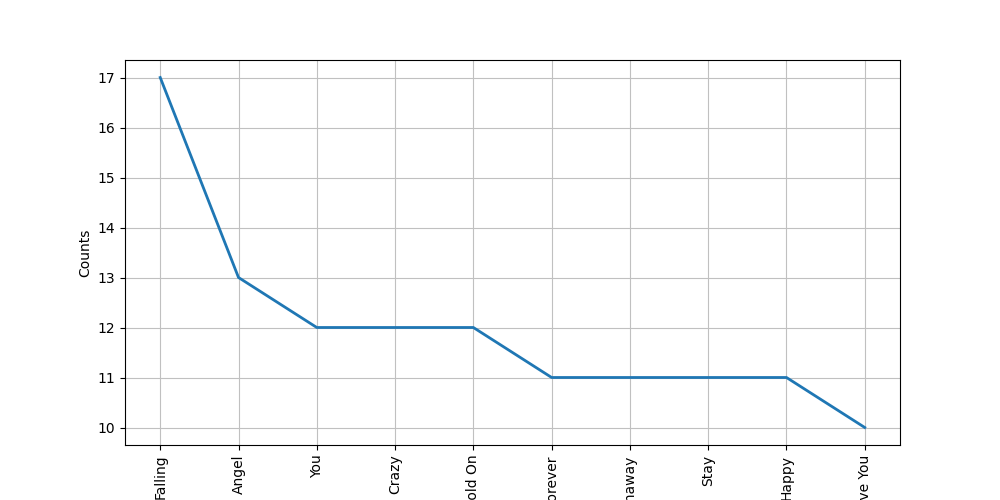

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [27]:
%matplotlib notebook
import nltk
from src.dataset_utils import *

columns_to_drop = ['uri']

dataset_full_nlp = get_full_dataset(columns_to_drop=columns_to_drop)

tokens = dataset_full_nlp['track'].values

freq = nltk.FreqDist(tokens)
fig.tight_layout()
freq.plot(10, cumulative=False)

In [1]:
from src.generate_features import *
from src.train_model import *
from src.score_model import *
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


dataset_full = generate_dataset(type='nlp', test=1)

x_train, x_test, y_train, y_test = get_train_test(dataset_full=dataset_full)

RF, y_pred = train_model(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, model_name='RF')


accuracy, precision, recall, f1 = evaluate_model(x_train, x_test, y_train, y_test, y_pred, RF)

# we save the model.
filename = 'deploy/model-spotify-full-dataset-nlp.sav'
joblib.dump(RF, filename)


Index(['COLUMNS: decade', 'COLUMNS: track', 'COLUMNS: artist',
       'COLUMNS: danceability', 'COLUMNS: energy', 'COLUMNS: key',
       'COLUMNS: loudness', 'COLUMNS: mode', 'COLUMNS: speechiness',
       'COLUMNS: acousticness', 'COLUMNS: instrumentalness',
       'COLUMNS: liveness', 'COLUMNS: valence', 'COLUMNS: tempo',
       'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')
NULL ARTIST: 0
artist part
['Garland Green' 'Serge Gainsbourg' 'Lord Melody' ... 'Regentum'
 'Liam Payne Featuring Quavo' 'The Neighbourhood']


D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\nltk_test\generate_features_nltk.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_full['has_hits'][dataset_full['artist'] == artist] = 1
D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\nltk_test\generate_features_nltk.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_full['has_hits'][dataset_full['artist'] == artist] = 0


NLP Part
41106


D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\nltk_test\generate_features_nltk.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_full['top10'][i] = decide(dataset_full['track'][i].split(), freq)


top10               0
has_hits            0
decade              0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
chorus_hit          0
sections            0
target              0
dtype: int64


D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = dataset_full.drop(['target'], 1).values  # values converts it into a numpy array


Accuracy: 80.07783994162004
Precision: 76.55838454784899
Recall: 85.95367175948743
F1 score: 0.8098444392848851
Training MSE:  0.0004257389611969347
Test model MSE 0.19922160058379956


['deploy/model-spotify-full-dataset-nlp.sav']

In [2]:
score = hyperparameter_search(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, model_name='RF')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   3.1s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   2.8s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   3.1s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   3.9s
[CV] END bootstrap=True, criterion=gini, max_depth=13, max_features=log2, min_samples_leaf=17, min_samples_split=20, n_estimators=65; total time=   3.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=18, max_features=log2, min_samples_leaf=6, min_samples_split=5, n

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=50; total time=   6.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=50; total time=   6.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=50; total time=   5.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=50; total time=   7.7s
[CV] END bootstrap=False, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=18, min_samples_split=20, n_estimators=50; total time=   5.6s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=20, max_features=sqrt, min_samples_leaf=1, mi

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=500; total time=  44.0s
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=500; total time=  41.3s
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=500; total time=  41.8s
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=500; total time=  40.6s
[CV] END bootstrap=False, criterion=gini, max_depth=17, max_features=sqrt, min_samples_leaf=7, min_samples_split=16, n_estimators=500; total time=  45.3s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=gini, max_depth=19, max_features=sqrt, min_samples_leaf=20, min_samples_spli

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=20, n_estimators=109; total time=  12.4s
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=20, n_estimators=109; total time=  11.9s
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=20, n_estimators=109; total time=  11.3s
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=20, n_estimators=109; total time=  12.0s
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=7, min_samples_split=20, n_estimators=109; total time=  12.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END bootstrap=False, criterion=entropy, max_depth=17, max_features=log2, min_samples_leaf=13

Aleshores, veient que no obtenia massa canvi, vaig decidir i seguin el consell del professor, provar el TFIDF Vectorizer. A la funció generate_dataset ficant test=0, crida el codi que genera el vector amb TFIDF.

In [3]:
dataset_full = generate_dataset(type='nlp', test=0)

x_train, x_test, y_train, y_test = get_train_test(dataset_full=dataset_full)

RF, y_pred = train_model(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, model_name='RF')


accuracy, precision, recall, f1 = evaluate_model(x_train, x_test, y_train, y_test, y_pred, RF)

# we save the model.
filename = 'deploy/model-spotify-full-dataset-nlp.sav'
joblib.dump(RF, filename)

Index(['COLUMNS: decade', 'COLUMNS: track', 'COLUMNS: artist',
       'COLUMNS: danceability', 'COLUMNS: energy', 'COLUMNS: key',
       'COLUMNS: loudness', 'COLUMNS: mode', 'COLUMNS: speechiness',
       'COLUMNS: acousticness', 'COLUMNS: instrumentalness',
       'COLUMNS: liveness', 'COLUMNS: valence', 'COLUMNS: tempo',
       'COLUMNS: duration_ms', 'COLUMNS: time_signature',
       'COLUMNS: chorus_hit', 'COLUMNS: sections', 'COLUMNS: target'],
      dtype='object')


c:\users\elblo\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Desktop\Universidad\3r Año\1r Semestre\APC\Kaggle\MD3 Spotify\src\train_model.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x = dataset_full.drop(['target'], 1).values  # values converts it into a numpy array


Accuracy: 79.99270250547312
Precision: 76.67477338049967
Recall: 85.4608181370133
F1 score: 0.8082974012352874
Training MSE:  0.0004865588127964968
Test model MSE 0.2000729749452688


['deploy/model-spotify-full-dataset-nlp.sav']

Com podem observar, no obtenim massa milloria, al contrari, estem perdent una mica de rendiment.

# Conclusions

Hem observat com hem obtingut un model el qual presenta un bon rendiment i metriques, pero que aquest podria ser millor si li donem més dades, o per exemple  intentem buscar altres dades d'entrada que el creador original del dataset no va tenir en compte com pot ser informació del autor de la cançó, genere de la cançó, etc..

També, hem vist com l'exit be predefinit en totes les decades per les mateixes caracteristiques de la cançó, com per exemple la tonalitat,  que hem vist sempre era voltant C, pero hi ha altres elements que crec si estaben més lligats a la societat en general, la qual no tota coneix aquests tecnicismes. Em refereixo a que per exemple, en les decades abans del 2000 potser li donaven més importancia o agradaba cançons no tan ballavles tipo balades o rock, i actualment trobem que en les decades actuals hi ha una tendencia cap el reggaeton, cançons que tindran un grau de ball elevat.

Finalment, crec que les proves que he fet amb NLP podrien haver estat millor, o potser son incorrectes, pero el meu coneixement sobre TFIDFVectorizer o NLP era molt baix abans del cas Kaggle i tot aixi, he arribat a apendre més d'aquests problemes de tractament de text que m'ha semblat molt interesant.